# Perbandingan Model Vision Transformer
## ViT vs Swin Transformer vs DeiT

**Mata Kuliah:** Deep Learning  
**Tugas:** Eksplorasi dan Perbandingan Model Vision Transformer

---

Notebook ini membandingkan 3 model Vision Transformer:
1. **Vision Transformer (ViT)** - Model transformer murni untuk visi
2. **Swin Transformer** - Hierarchical transformer dengan shifted window attention
3. **DeiT** - Data-efficient Image Transformer dengan knowledge distillation

## 1. Import Libraries dan Setup

In [1]:
# Install required packages
!pip install torch torchvision timm matplotlib seaborn scikit-learn pandas numpy pillow tqdm -q

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, datasets
import timm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time
import os
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


## 2. Configuration dan Hyperparameters

In [3]:
# Hyperparameters
CONFIG = {
    'img_size': 224,
    'batch_size': 32,
    'num_epochs': 20,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'num_workers': 2,
    'patience': 5,  # Early stopping patience
}

# Model configurations
MODEL_CONFIGS = {
    'vit': {
        'name': 'vit_base_patch16_224',
        'pretrained': True,
        'description': 'Vision Transformer Base (Patch 16)'
    },
    'swin': {
        'name': 'swin_base_patch4_window7_224',
        'pretrained': True,
        'description': 'Swin Transformer Base (Window 7)'
    },
    'deit': {
        'name': 'deit_base_patch16_224',
        'pretrained': True,
        'description': 'DeiT Base (Patch 16)'
    }
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  img_size: 224
  batch_size: 32
  num_epochs: 20
  learning_rate: 0.0001
  weight_decay: 0.0001
  num_workers: 2
  patience: 5


## 3. Data Loading dan Preprocessing

Pada bagian ini, kita akan menggunakan CIFAR-10 sebagai contoh. Anda dapat mengganti dengan dataset Indonesian Food atau dataset lainnya.

In [4]:
# Data augmentation and preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset (you can replace with your custom dataset)
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transforms
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=val_transforms
)

# Create validation split from training data
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

# Dataset information
NUM_CLASSES = 10
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"\nDataset Information:")
print(f"  Train set: {len(train_dataset)} images")
print(f"  Validation set: {len(val_dataset)} images")
print(f"  Test set: {len(test_dataset)} images")
print(f"  Number of classes: {NUM_CLASSES}")
print(f"  Classes: {CLASS_NAMES}")

100%|██████████| 170M/170M [09:57<00:00, 285kB/s]  



Dataset Information:
  Train set: 40000 images
  Validation set: 10000 images
  Test set: 10000 images
  Number of classes: 10
  Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Visualisasi Sample Data

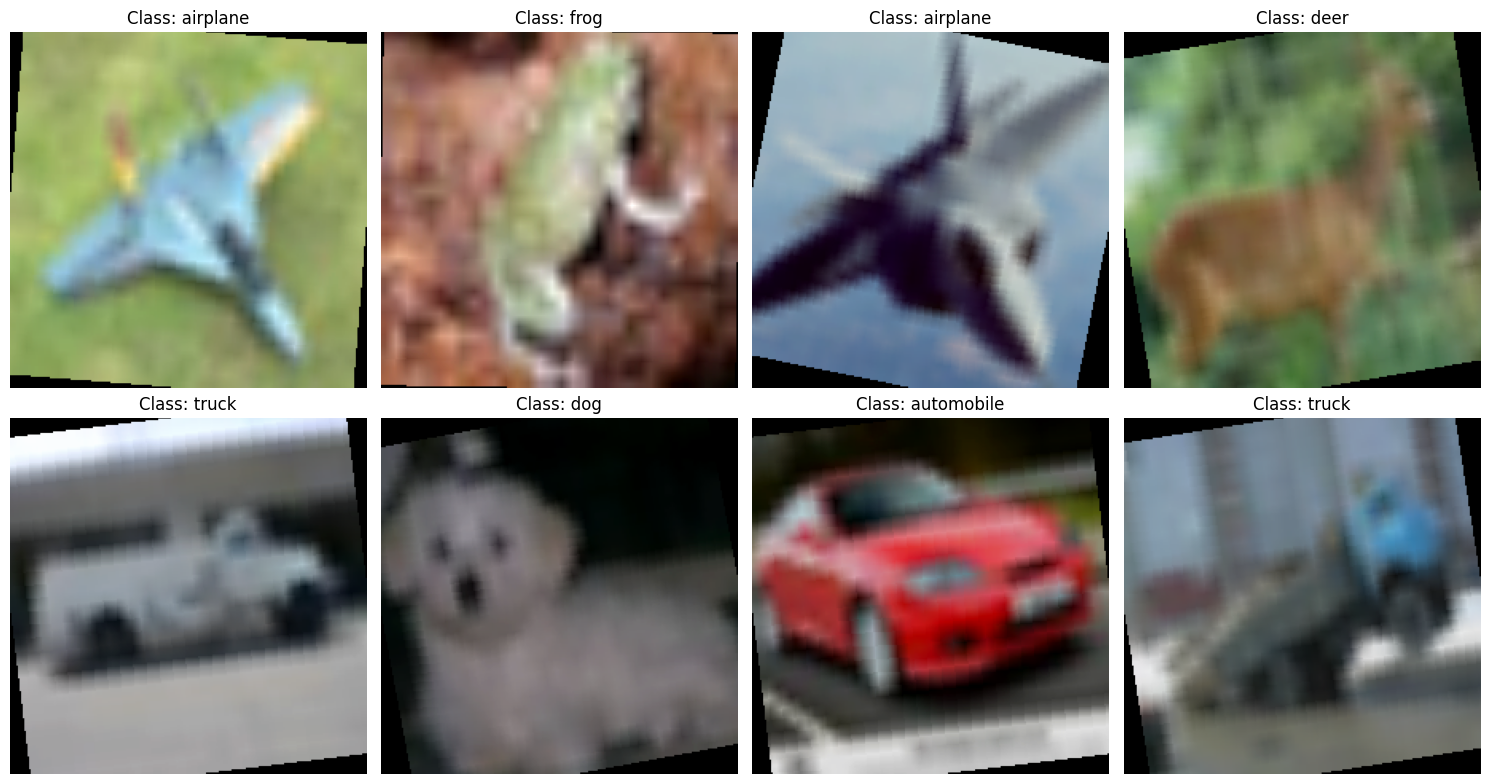

In [5]:
def visualize_samples(loader, num_samples=8):
    """Visualize sample images from the dataset"""
    images, labels = next(iter(loader))
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    for idx in range(num_samples):
        # Denormalize image
        img = images[idx].cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axes[idx].imshow(img)
        axes[idx].set_title(f'Class: {CLASS_NAMES[labels[idx]]}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(train_loader)

## 4. Model Definition dan Parameter Analysis

In [6]:
def create_model(model_name, num_classes=NUM_CLASSES, pretrained=True):
    """Create a Vision Transformer model"""
    model = timm.create_model(
        model_name,
        pretrained=pretrained,
        num_classes=num_classes
    )
    return model

def count_parameters(model):
    """Count model parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    
    return {
        'total': total_params,
        'trainable': trainable_params,
        'non_trainable': non_trainable_params,
        'size_mb': total_params * 4 / (1024 ** 2)  # Assuming float32
    }

# Create models and analyze parameters
models = {}
param_stats = {}

print("Creating models and analyzing parameters...\n")
print("=" * 80)

for model_key, config in MODEL_CONFIGS.items():
    print(f"\n{config['description']}")
    print("-" * 80)
    
    # Create model
    model = create_model(
        config['name'],
        num_classes=NUM_CLASSES,
        pretrained=config['pretrained']
    )
    model = model.to(device)
    models[model_key] = model
    
    # Count parameters
    params = count_parameters(model)
    param_stats[model_key] = params
    
    print(f"Total Parameters: {params['total']:,}")
    print(f"Trainable Parameters: {params['trainable']:,}")
    print(f"Non-trainable Parameters: {params['non_trainable']:,}")
    print(f"Model Size: {params['size_mb']:.2f} MB")

print("\n" + "=" * 80)

Creating models and analyzing parameters...


Vision Transformer Base (Patch 16)
--------------------------------------------------------------------------------


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Total Parameters: 85,806,346
Trainable Parameters: 85,806,346
Non-trainable Parameters: 0
Model Size: 327.33 MB

Swin Transformer Base (Window 7)
--------------------------------------------------------------------------------


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Total Parameters: 86,753,474
Trainable Parameters: 86,753,474
Non-trainable Parameters: 0
Model Size: 330.94 MB

DeiT Base (Patch 16)
--------------------------------------------------------------------------------


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Total Parameters: 85,806,346
Trainable Parameters: 85,806,346
Non-trainable Parameters: 0
Model Size: 327.33 MB



### Parameter Comparison Table


Parameter Comparison:
                                    Total Params  Trainable Params  \
Vision Transformer Base (Patch 16)    85806346.0        85806346.0   
Swin Transformer Base (Window 7)      86753474.0        86753474.0   
DeiT Base (Patch 16)                  85806346.0        85806346.0   

                                    Non-trainable Params   Size (MB)  
Vision Transformer Base (Patch 16)                   0.0  327.325233  
Swin Transformer Base (Window 7)                     0.0  330.938240  
DeiT Base (Patch 16)                                 0.0  327.325233  


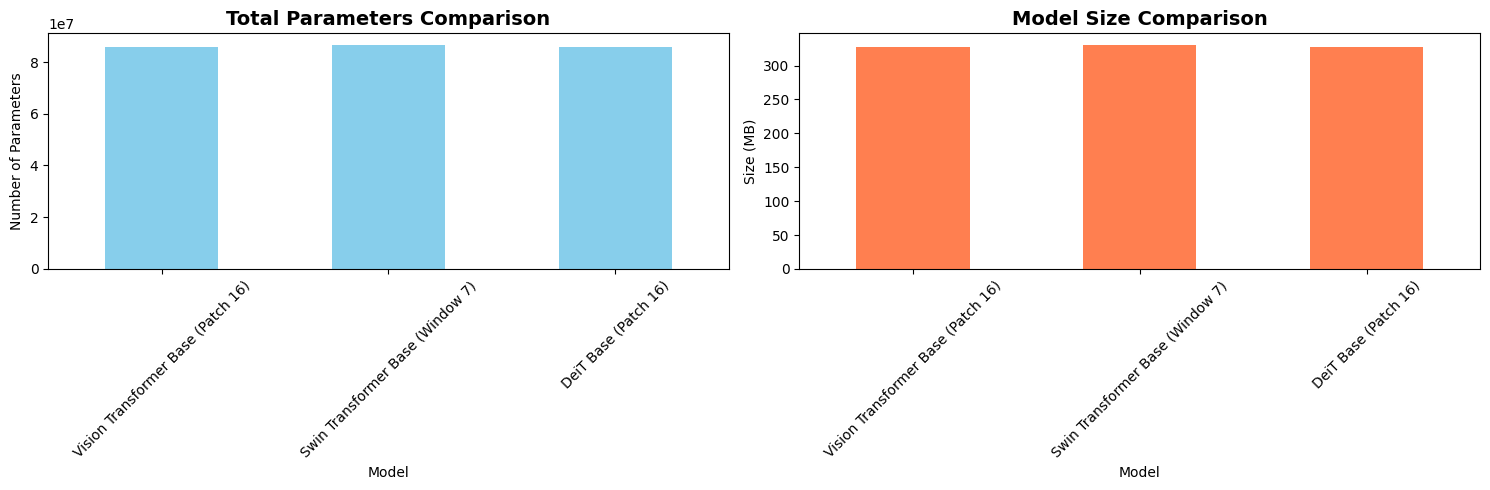

In [7]:
# Create parameter comparison table
param_df = pd.DataFrame(param_stats).T
param_df.index = [MODEL_CONFIGS[k]['description'] for k in param_df.index]
param_df.columns = ['Total Params', 'Trainable Params', 'Non-trainable Params', 'Size (MB)']

print("\nParameter Comparison:")
print(param_df)

# Visualize parameter comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Total Parameters
param_df['Total Params'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Total Parameters Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Parameters')
axes[0].set_xlabel('Model')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Model Size
param_df['Size (MB)'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Model Size Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Size (MB)')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Training Functions

In [8]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100. * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100. * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, num_epochs, learning_rate, 
                weight_decay, patience, device, model_name):
    """Complete training loop with early stopping"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"\nTraining {model_name}...")
    print("=" * 80)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 80)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch summary
        print(f"\nEpoch Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"  ✓ Best model updated!")
        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print("\n" + "=" * 80)
    print("Training completed!")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    
    return model, history

## 6. Train All Models

In [ ]:
# Dictionary to store trained models and histories
trained_models = {}
training_histories = {}

# Train each model
for model_key in MODEL_CONFIGS.keys():
    model_name = MODEL_CONFIGS[model_key]['description']
    
    print(f"\n\n{'='*80}")
    print(f"Training: {model_name}")
    print(f"{'='*80}\n")
    
    # Train model
    trained_model, history = train_model(
        model=models[model_key],
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=CONFIG['num_epochs'],
        learning_rate=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay'],
        patience=CONFIG['patience'],
        device=device,
        model_name=model_name
    )
    
    # Store results
    trained_models[model_key] = trained_model
    training_histories[model_key] = history
    
    # Save model checkpoint
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'history': history,
        'config': MODEL_CONFIGS[model_key]
    }, f'{model_key}_checkpoint.pth')
    
    print(f"\nModel checkpoint saved: {model_key}_checkpoint.pth")

print("\n\nAll models trained successfully!")



Training: Vision Transformer Base (Patch 16)


Training Vision Transformer Base (Patch 16)...

Epoch 1/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.2889 | Train Acc: 90.72%
  Val Loss: 0.2349 | Val Acc: 92.10%
  LR: 0.000100
  ✓ Best model updated!

Epoch 2/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.1860 | Train Acc: 93.90%
  Val Loss: 0.1842 | Val Acc: 93.85%
  LR: 0.000100
  ✓ Best model updated!

Epoch 3/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a7110be4a40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a7110be4a40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

## 7. Visualize Training History

In [ ]:
def plot_training_history(histories, model_configs):
    """Plot training and validation metrics for all models"""
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Plot Training Loss
    for idx, (model_key, history) in enumerate(histories.items()):
        model_name = model_configs[model_key]['description']
        axes[0, 0].plot(history['train_loss'], label=model_name, 
                       color=colors[idx], linewidth=2)
    axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot Validation Loss
    for idx, (model_key, history) in enumerate(histories.items()):
        model_name = model_configs[model_key]['description']
        axes[0, 1].plot(history['val_loss'], label=model_name, 
                       color=colors[idx], linewidth=2)
    axes[0, 1].set_title('Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot Training Accuracy
    for idx, (model_key, history) in enumerate(histories.items()):
        model_name = model_configs[model_key]['description']
        axes[1, 0].plot(history['train_acc'], label=model_name, 
                       color=colors[idx], linewidth=2)
    axes[1, 0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot Validation Accuracy
    for idx, (model_key, history) in enumerate(histories.items()):
        model_name = model_configs[model_key]['description']
        axes[1, 1].plot(history['val_acc'], label=model_name, 
                       color=colors[idx], linewidth=2)
    axes[1, 1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(training_histories, MODEL_CONFIGS)

## 8. Model Evaluation on Test Set

In [ ]:
def evaluate_model(model, test_loader, device):
    """Evaluate model on test set"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_labels), np.array(all_preds)

# Evaluate all models
test_results = {}

print("Evaluating models on test set...\n")
print("=" * 80)

for model_key in MODEL_CONFIGS.keys():
    model_name = MODEL_CONFIGS[model_key]['description']
    print(f"\nEvaluating {model_name}...")
    
    # Get predictions
    true_labels, predictions = evaluate_model(
        trained_models[model_key], 
        test_loader, 
        device
    )
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='weighted'
    )
    
    # Per-class metrics
    per_class_precision, per_class_recall, per_class_f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average=None
    )
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    # Store results
    test_results[model_key] = {
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1_score': f1 * 100,
        'per_class_precision': per_class_precision * 100,
        'per_class_recall': per_class_recall * 100,
        'per_class_f1': per_class_f1 * 100,
        'confusion_matrix': cm,
        'predictions': predictions,
        'true_labels': true_labels
    }
    
    # Print results
    print(f"\nTest Results for {model_name}:")
    print(f"  Accuracy: {accuracy * 100:.2f}%")
    print(f"  Precision: {precision * 100:.2f}%")
    print(f"  Recall: {recall * 100:.2f}%")
    print(f"  F1-Score: {f1 * 100:.2f}%")

print("\n" + "=" * 80)
print("Evaluation completed!")

### Performance Metrics Comparison Table

In [ ]:
# Create performance comparison table
performance_data = []

for model_key in MODEL_CONFIGS.keys():
    model_name = MODEL_CONFIGS[model_key]['description']
    results = test_results[model_key]
    
    performance_data.append({
        'Model': model_name,
        'Accuracy (%)': f"{results['accuracy']:.2f}",
        'Precision (%)': f"{results['precision']:.2f}",
        'Recall (%)': f"{results['recall']:.2f}",
        'F1-Score (%)': f"{results['f1_score']:.2f}"
    })

performance_df = pd.DataFrame(performance_data)
print("\nPerformance Metrics Comparison:")
print(performance_df.to_string(index=False))

# Save to CSV
performance_df.to_csv('performance_comparison.csv', index=False)
print("\nPerformance comparison saved to: performance_comparison.csv")

### Visualize Performance Metrics

In [ ]:
# Plot performance comparison
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.25

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, model_key in enumerate(MODEL_CONFIGS.keys()):
    model_name = MODEL_CONFIGS[model_key]['description']
    results = test_results[model_key]
    
    values = [
        results['accuracy'],
        results['precision'],
        results['recall'],
        results['f1_score']
    ]
    
    ax.bar(x + idx * width, values, width, label=model_name, color=colors[idx])

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 105])

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Confusion Matrices

In [ ]:
def plot_confusion_matrices(test_results, model_configs, class_names):
    """Plot confusion matrices for all models"""
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for idx, model_key in enumerate(model_configs.keys()):
        model_name = model_configs[model_key]['description']
        cm = test_results[model_key]['confusion_matrix']
        
        # Normalize confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Plot
        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt='.2f',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axes[idx],
            cbar_kws={'label': 'Proportion'}
        )
        
        axes[idx].set_title(f'{model_name}\nConfusion Matrix', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_confusion_matrices(test_results, MODEL_CONFIGS, CLASS_NAMES)

## 10. Per-Class Performance Analysis

In [ ]:
# Create per-class performance table for each model
for model_key in MODEL_CONFIGS.keys():
    model_name = MODEL_CONFIGS[model_key]['description']
    results = test_results[model_key]
    
    per_class_data = []
    for i, class_name in enumerate(CLASS_NAMES):
        per_class_data.append({
            'Class': class_name,
            'Precision (%)': f"{results['per_class_precision'][i]:.2f}",
            'Recall (%)': f"{results['per_class_recall'][i]:.2f}",
            'F1-Score (%)': f"{results['per_class_f1'][i]:.2f}"
        })
    
    per_class_df = pd.DataFrame(per_class_data)
    print(f"\n{model_name} - Per-Class Performance:")
    print("=" * 60)
    print(per_class_df.to_string(index=False))
    
    # Save to CSV
    per_class_df.to_csv(f'{model_key}_per_class_performance.csv', index=False)

## 11. Inference Time Measurement

In [ ]:
def measure_inference_time(model, test_loader, device, num_iterations=100):
    """Measure inference time"""
    model.eval()
    
    # Warm-up
    print("Warming up...")
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            if i >= 10:  # 10 warm-up iterations
                break
            images = images.to(device)
            _ = model(images)
    
    # Measure inference time
    print(f"Measuring inference time over {num_iterations} iterations...")
    times = []
    total_images = 0
    
    with torch.no_grad():
        for i, (images, _) in enumerate(tqdm(test_loader, desc='Measuring')):
            if i >= num_iterations:
                break
            
            images = images.to(device)
            batch_size = images.size(0)
            
            # Synchronize GPU
            if device.type == 'cuda':
                torch.cuda.synchronize()
            
            start_time = time.time()
            _ = model(images)
            
            # Synchronize GPU
            if device.type == 'cuda':
                torch.cuda.synchronize()
            
            end_time = time.time()
            
            batch_time = (end_time - start_time) * 1000  # Convert to ms
            times.append(batch_time)
            total_images += batch_size
    
    # Calculate statistics
    times = np.array(times)
    mean_time = np.mean(times)
    std_time = np.std(times)
    total_time = np.sum(times)
    avg_time_per_image = total_time / total_images
    throughput = 1000 / avg_time_per_image  # images per second
    
    return {
        'mean_batch_time_ms': mean_time,
        'std_batch_time_ms': std_time,
        'total_time_ms': total_time,
        'avg_time_per_image_ms': avg_time_per_image,
        'throughput_fps': throughput,
        'num_images': total_images
    }

# Measure inference time for all models
inference_times = {}

print("\n" + "=" * 80)
print("INFERENCE TIME MEASUREMENT")
print("=" * 80)

for model_key in MODEL_CONFIGS.keys():
    model_name = MODEL_CONFIGS[model_key]['description']
    print(f"\n{model_name}")
    print("-" * 80)
    
    timing_stats = measure_inference_time(
        trained_models[model_key],
        test_loader,
        device,
        num_iterations=100
    )
    
    inference_times[model_key] = timing_stats
    
    print(f"\nInference Time Statistics:")
    print(f"  Mean Batch Time: {timing_stats['mean_batch_time_ms']:.2f} ± {timing_stats['std_batch_time_ms']:.2f} ms")
    print(f"  Avg Time per Image: {timing_stats['avg_time_per_image_ms']:.2f} ms")
    print(f"  Throughput: {timing_stats['throughput_fps']:.2f} images/second")
    print(f"  Total Images Processed: {timing_stats['num_images']}")

print("\n" + "=" * 80)

### Inference Time Comparison

In [ ]:
# Create inference time comparison table
inference_data = []

for model_key in MODEL_CONFIGS.keys():
    model_name = MODEL_CONFIGS[model_key]['description']
    stats = inference_times[model_key]
    
    inference_data.append({
        'Model': model_name,
        'Avg Time/Image (ms)': f"{stats['avg_time_per_image_ms']:.2f}",
        'Throughput (FPS)': f"{stats['throughput_fps']:.2f}",
        'Batch Time (ms)': f"{stats['mean_batch_time_ms']:.2f} ± {stats['std_batch_time_ms']:.2f}"
    })

inference_df = pd.DataFrame(inference_data)
print("\nInference Time Comparison:")
print(inference_df.to_string(index=False))

# Save to CSV
inference_df.to_csv('inference_time_comparison.csv', index=False)
print("\nInference time comparison saved to: inference_time_comparison.csv")

### Visualize Inference Time

In [ ]:
# Plot inference time comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

model_names = [MODEL_CONFIGS[k]['description'] for k in MODEL_CONFIGS.keys()]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot 1: Average Time per Image
avg_times = [inference_times[k]['avg_time_per_image_ms'] for k in MODEL_CONFIGS.keys()]
axes[0].bar(model_names, avg_times, color=colors)
axes[0].set_title('Average Inference Time per Image', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Time (ms)')
axes[0].set_xlabel('Model')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(avg_times):
    axes[0].text(i, v + 0.5, f'{v:.2f}', ha='center', va='bottom')

# Plot 2: Throughput
throughputs = [inference_times[k]['throughput_fps'] for k in MODEL_CONFIGS.keys()]
axes[1].bar(model_names, throughputs, color=colors)
axes[1].set_title('Throughput (Images per Second)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Images/Second')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(throughputs):
    axes[1].text(i, v + 1, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('inference_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Comprehensive Comparison Summary

In [ ]:
# Create comprehensive comparison table
comparison_data = []

for model_key in MODEL_CONFIGS.keys():
    model_name = MODEL_CONFIGS[model_key]['description']
    
    comparison_data.append({
        'Model': model_name,
        'Total Params': f"{param_stats[model_key]['total']:,}",
        'Size (MB)': f"{param_stats[model_key]['size_mb']:.2f}",
        'Accuracy (%)': f"{test_results[model_key]['accuracy']:.2f}",
        'F1-Score (%)': f"{test_results[model_key]['f1_score']:.2f}",
        'Inference Time (ms)': f"{inference_times[model_key]['avg_time_per_image_ms']:.2f}",
        'Throughput (FPS)': f"{inference_times[model_key]['throughput_fps']:.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "=" * 100)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Save to CSV
comparison_df.to_csv('comprehensive_comparison.csv', index=False)
print("\nComprehensive comparison saved to: comprehensive_comparison.csv")

## 13. Trade-off Analysis

In [ ]:
# Create trade-off visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

model_names = [MODEL_CONFIGS[k]['description'] for k in MODEL_CONFIGS.keys()]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot 1: Accuracy vs Parameters
accuracies = [test_results[k]['accuracy'] for k in MODEL_CONFIGS.keys()]
params = [param_stats[k]['total'] / 1e6 for k in MODEL_CONFIGS.keys()]  # In millions

for i, (name, acc, param) in enumerate(zip(model_names, accuracies, params)):
    axes[0].scatter(param, acc, s=300, c=colors[i], alpha=0.6, edgecolors='black', linewidth=2)
    axes[0].annotate(name, (param, acc), fontsize=10, ha='center', va='bottom')

axes[0].set_xlabel('Number of Parameters (Millions)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Accuracy vs Model Size', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy vs Inference Time
inf_times = [inference_times[k]['avg_time_per_image_ms'] for k in MODEL_CONFIGS.keys()]

for i, (name, acc, inf_time) in enumerate(zip(model_names, accuracies, inf_times)):
    axes[1].scatter(inf_time, acc, s=300, c=colors[i], alpha=0.6, edgecolors='black', linewidth=2)
    axes[1].annotate(name, (inf_time, acc), fontsize=10, ha='center', va='bottom')

axes[1].set_xlabel('Inference Time (ms/image)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Accuracy vs Inference Speed', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tradeoff_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. Sample Predictions Visualization

In [ ]:
def visualize_predictions(models, test_loader, device, class_names, num_samples=6):
    """Visualize predictions from all models on the same images"""
    # Get a batch of images
    images, true_labels = next(iter(test_loader))
    images = images[:num_samples]
    true_labels = true_labels[:num_samples]
    
    # Get predictions from all models
    predictions = {}
    for model_key, model in models.items():
        model.eval()
        with torch.no_grad():
            outputs = model(images.to(device))
            _, preds = outputs.max(1)
            predictions[model_key] = preds.cpu().numpy()
    
    # Visualize
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for idx in range(num_samples):
        # Denormalize image
        img = images[idx].cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axes[idx].imshow(img)
        
        # Create title with all predictions
        true_class = class_names[true_labels[idx]]
        title = f"True: {true_class}\n"
        
        for model_key in MODEL_CONFIGS.keys():
            pred_class = class_names[predictions[model_key][idx]]
            model_short = model_key.upper()
            
            # Color code correct/incorrect predictions
            if predictions[model_key][idx] == true_labels[idx]:
                title += f"{model_short}: {pred_class} ✓\n"
            else:
                title += f"{model_short}: {pred_class} ✗\n"
        
        axes[idx].set_title(title, fontsize=10)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions(trained_models, test_loader, device, CLASS_NAMES, num_samples=6)

## 15. Final Summary and Recommendations

In [ ]:
print("\n" + "=" * 100)
print("FINAL ANALYSIS AND RECOMMENDATIONS")
print("=" * 100)

# Find best model for each criterion
best_accuracy = max(MODEL_CONFIGS.keys(), key=lambda k: test_results[k]['accuracy'])
best_speed = min(MODEL_CONFIGS.keys(), key=lambda k: inference_times[k]['avg_time_per_image_ms'])
smallest_model = min(MODEL_CONFIGS.keys(), key=lambda k: param_stats[k]['total'])

print("\n📊 Best Performance by Criterion:")
print("-" * 100)
print(f"\n🎯 Highest Accuracy: {MODEL_CONFIGS[best_accuracy]['description']}")
print(f"   Accuracy: {test_results[best_accuracy]['accuracy']:.2f}%")
print(f"   F1-Score: {test_results[best_accuracy]['f1_score']:.2f}%")

print(f"\n⚡ Fastest Inference: {MODEL_CONFIGS[best_speed]['description']}")
print(f"   Inference Time: {inference_times[best_speed]['avg_time_per_image_ms']:.2f} ms/image")
print(f"   Throughput: {inference_times[best_speed]['throughput_fps']:.2f} FPS")

print(f"\n💾 Most Efficient (Smallest): {MODEL_CONFIGS[smallest_model]['description']}")
print(f"   Parameters: {param_stats[smallest_model]['total']:,}")
print(f"   Size: {param_stats[smallest_model]['size_mb']:.2f} MB")

print("\n" + "=" * 100)
print("\n💡 RECOMMENDATIONS:")
print("-" * 100)

print("\n1. For Maximum Accuracy:")
print(f"   → Choose {MODEL_CONFIGS[best_accuracy]['description']}")
print("   → Best for: Research, benchmarking, offline processing")
print("   → Trade-off: Higher computational cost")

print("\n2. For Real-time Applications:")
print(f"   → Choose {MODEL_CONFIGS[best_speed]['description']}")
print("   → Best for: Edge devices, mobile apps, real-time inference")
print("   → Trade-off: May have slightly lower accuracy")

print("\n3. For Resource-Constrained Environments:")
print(f"   → Choose {MODEL_CONFIGS[smallest_model]['description']}")
print("   → Best for: Limited memory/storage, embedded systems")
print("   → Trade-off: Balance between size and performance")

print("\n" + "=" * 100)

# Save final summary
summary = {
    'best_accuracy_model': MODEL_CONFIGS[best_accuracy]['description'],
    'best_accuracy_value': test_results[best_accuracy]['accuracy'],
    'fastest_model': MODEL_CONFIGS[best_speed]['description'],
    'fastest_inference_time': inference_times[best_speed]['avg_time_per_image_ms'],
    'smallest_model': MODEL_CONFIGS[smallest_model]['description'],
    'smallest_model_params': param_stats[smallest_model]['total'],
}

with open('final_summary.txt', 'w') as f:
    f.write("Vision Transformer Comparison - Final Summary\n")
    f.write("=" * 60 + "\n\n")
    for key, value in summary.items():
        f.write(f"{key}: {value}\n")

print("\n✅ All results saved successfully!")
print("\nGenerated files:")
print("  - performance_comparison.csv")
print("  - inference_time_comparison.csv")
print("  - comprehensive_comparison.csv")
print("  - training_history.png")
print("  - performance_comparison.png")
print("  - confusion_matrices.png")
print("  - inference_time_comparison.png")
print("  - tradeoff_analysis.png")
print("  - sample_predictions.png")
print("  - final_summary.txt")
print("  - [model]_checkpoint.pth (for each model)")

## 16. Export Results for Report

In [ ]:
# Create a comprehensive results dictionary for easy access in report
final_results = {
    'models': MODEL_CONFIGS,
    'parameters': param_stats,
    'performance': test_results,
    'inference_time': inference_times,
    'training_history': training_histories,
    'config': CONFIG
}

# Save as pickle for later use
import pickle
with open('experiment_results.pkl', 'wb') as f:
    pickle.dump(final_results, f)

print("All results saved to experiment_results.pkl")
print("\nYou can load this file later using:")
print("with open('experiment_results.pkl', 'rb') as f:")
print("    results = pickle.load(f)")

---

## Experiment Complete! 🎉

Notebook ini telah berhasil:
1. ✅ Mengimplementasikan 3 model Vision Transformer (ViT, Swin, DeiT)
2. ✅ Melatih semua model dengan fair comparison
3. ✅ Menganalisis jumlah parameter dan ukuran model
4. ✅ Mengukur metrik performa (Accuracy, Precision, Recall, F1-Score)
5. ✅ Mengukur waktu inferensi dan throughput
6. ✅ Membuat visualisasi lengkap
7. ✅ Menghasilkan laporan perbandingan

**Langkah selanjutnya:**
- Gunakan hasil dan visualisasi untuk laporan LaTeX
- Analisis trade-off antara accuracy, speed, dan model size
- Buat kesimpulan dan rekomendasi berdasarkan hasil eksperimen